In [35]:
import os

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset import MirexDataset, MirexFameDataset
from models.cnn import model
from utils import get_chord_labels

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
model.load_state_dict(torch.load('results/best_model.pt', map_location=device))
model.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (bnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (bnorm5): BatchNorm2

In [29]:
chord_dataset = MirexDataset(audio_dir="data/robbie_williams/mp3/2000-Sing When You're Winning/",
                             ann_dir="data/robbie_williams/chordlabs/2000-Sing When You're Winning/",
                             window_size=8192, hop_length=4096)
# chord_dataset = MirexDataset(audio_dir="data/queen/mp3/Greatest_Hits_II/",
#                              ann_dir="data/queen/chordlabs/Greatest_Hits_II/",
#                              window_size=8192, hop_length=4096)
loader_chord = DataLoader(chord_dataset, batch_size=None, num_workers=0)

In [14]:
from container import ContextContainer
from metrics import compute_eval_measures

@torch.no_grad()
def estimate_chords(dataloader, model, device, scores_dir='scores'):
    model.eval()  # set model to evaluation mode
    
    if not os.path.exists(scores_dir):
        os.makedirs(scores_dir)
    
    criterion = nn.Softmax()
    for sample in dataloader:
        sample_name = sample['sample']
        chromagram = sample['chromagram']
        
        container = ContextContainer(chromagram, 7)
        result = torch.empty(25, chromagram.shape[1])
        for idx, frame in enumerate(container):
            frame = frame.view(1, 1, *frame.shape)
            
            inputs = frame.to(device=device, dtype=torch.float32)
            scores = model(inputs)
            scores = torch.squeeze(scores)
            scores = criterion(scores)

            result[:, idx] = scores
        
        _, preds = torch.max(result, 0)
        result = F.one_hot(preds, result.shape[0]).t_()

        ann_matrix = sample['ann_matrix'].data.numpy()
        result = result.data.numpy()
        
        P, R, F1, TP, FP, FN = compute_eval_measures(ann_matrix, result)
        title = f'Eval: (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f) - {sample_name}' % (result.shape[1], TP, FP, FN, P,R,F1)
        print(title)
        #break

In [30]:
estimate_chords(loader_chord, model, device)

Eval: (N=3220, TP=145, FP=3075, FN=2914, P=0.045, R=0.047, F=0.046) - 01-Let Love Be Your Energy
Eval: (N=2182, TP=421, FP=1761, FN=1362, P=0.193, R=0.236, F=0.212) - 02-Better Man
Eval: (N=2784, TP=249, FP=2535, FN=1261, P=0.089, R=0.165, F=0.116) - 03-Rock DJ
Eval: (N=2783, TP=664, FP=2119, FN=1877, P=0.239, R=0.261, F=0.249) - 04-Supreme
Eval: (N=3087, TP=521, FP=2566, FN=2566, P=0.169, R=0.169, F=0.169) - 05-Kids
Eval: (N=2696, TP=713, FP=1983, FN=1207, P=0.264, R=0.371, F=0.309) - 06-If It's Hurting You
Eval: (N=2925, TP=658, FP=2267, FN=1809, P=0.225, R=0.267, F=0.244) - 07-Singing For The Lonely
Eval: (N=2645, TP=322, FP=2323, FN=1192, P=0.122, R=0.213, F=0.155) - 08-Love Calling Earth
Eval: (N=3074, TP=229, FP=2845, FN=2432, P=0.074, R=0.086, F=0.080) - 09-Knutsford City Limits
Eval: (N=2343, TP=344, FP=1999, FN=1999, P=0.147, R=0.147, F=0.147) - 10-Forever Texas
Eval: (N=3076, TP=441, FP=2635, FN=2605, P=0.143, R=0.145, F=0.144) - 11-By All Means Necessary
Eval: (N=2594, TP=52

In [20]:
def calculate_chords(model, audio_path, ann_path, window_size=8192, hop_length=4096):
    from utils import convert_chord_ann_matrix
    audio_waveform, sampling_rate = librosa.core.load(audio_path, sr=None)
    chromagram = librosa.feature.chroma_stft(audio_waveform, sr=sampling_rate, norm=None,
                                             n_fft=window_size, hop_length=hop_length, tuning=0, n_chroma=105)
    criterion = nn.Softmax()
    container = ContextContainer(chromagram, 7)
    result = torch.empty(25, chromagram.shape[1])
    for idx, frame in enumerate(container):
        frame = frame.reshape(1, 1, *frame.shape)

        inputs = torch.from_numpy(frame)
        scores = model(inputs)

        scores = torch.squeeze(scores)
        scores = criterion(scores)
        result[:, idx] = scores

    _, preds = torch.max(result, 0)
    result = F.one_hot(preds, result.shape[0]).t_()
    result = result.data.numpy()
    
    
    chord_labels = get_chord_labels(ext_minor='m', nonchord=True)
    N_X = chromagram.shape[1]
    Fs_X = sampling_rate / hop_length
    ann_matrix, _, _, _ = convert_chord_ann_matrix(
            fn_ann=ann_path, chord_labels=chord_labels, Fs=Fs_X, N=N_X, last=False)
    return result, ann_matrix

In [21]:
def print_chords(chord_matrix):
    chord_labels = get_chord_labels(nonchord=True)
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    ax.set_yticks(np.arange(len(chord_labels)))
    ax.set_yticklabels(chord_labels)
    ax.set_title('Time–chord representation of chord recognition result')
    ax.pcolormesh(chord_matrix, cmap='coolwarm', alpha=0.7)

In [34]:
import time

start = time.time()
result, ann_matrix = calculate_chords(
    model=model,
    audio_path="data/robbie_williams/mp3/2000-Sing When You're Winning/01-Let Love Be Your Energy.mp3",
    ann_path="data/robbie_williams/chordlabs/2000-Sing When You're Winning/01-Let Love Be Your Energy.lab")
print(time.time() - start)

57.20123481750488


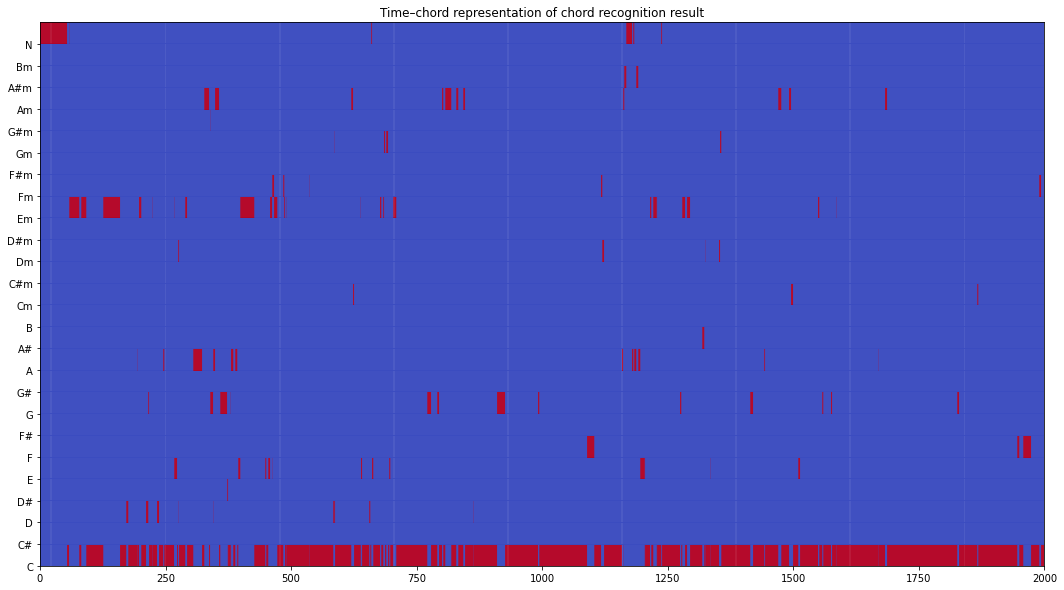

In [32]:
print_chords(result[:, :2000])

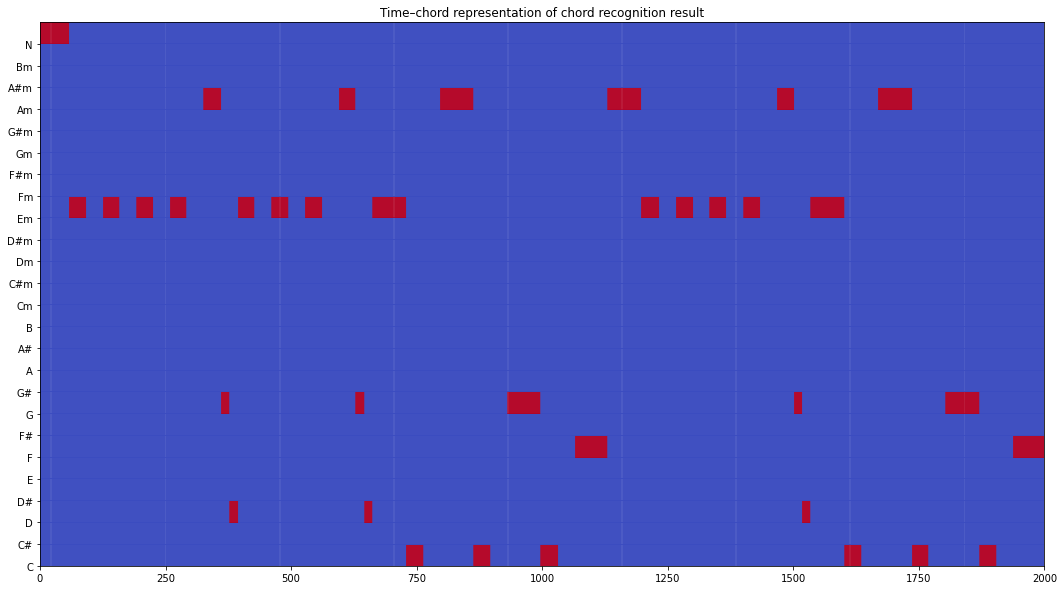

In [33]:
print_chords(ann_matrix[:, :2000])